Genotyping Sites with NumNeigh==0 is clearly easy. Let's measure how many SVs have NumNeigh==0 as you add more and more samples

In [104]:
from io import StringIO
import pandas as pd
import seaborn as sb
sb.set()

In [40]:
in_file = "../data/multi_merge/grch38/strict/strict.vcf.gz"
tmpfile = "../data/temp/grch38.s.s.vcf.gz "
!python ../scripts/only_svs.py {in_file} | truvari anno numneigh | bgzip > {tmpfile}
samps = !zgrep -m 1 "CHROM" ../data/temp/grch38.s.s.vcf.gz | cut -f10-
samps = samps[0].split('\t')

2021-07-27 06:55:09,289 [INFO] Running /raid/home/english/pyve/bin/truvari anno numneigh
2021-07-27 07:01:20,516 [INFO] Finished


In [41]:
#Sort samples by SV counts (descending)
raw_data = !bcftools query -f "[%GT\t]\n" {tmpfile}
raw_data2 = StringIO("\t".join(samps) + '\n' + "\n".join(raw_data))
data = pd.read_csv(raw_data2, header=0, sep='\t', index_col=False)

data = data.applymap(lambda x: x != "0/0")
samps = data.sum(axis=0).sort_values(ascending=False).index.to_list()

In [67]:
with open("tmp_script.sh", 'w') as fout:
    for i in range(len(samps)):
        view_samps = samps[:i + 1]
        cnt = len(view_samps)
        s = ",".join(view_samps)
        #%%bash --output out --error err
        # exclusive variants per sample
        #output = !bcftools view -x -s {s} {tmpfile} | truvari anno numneigh | bcftools query -f "%INFO/NumNeighbors\n" 2> /dev/null
        fout.write(f"vcf-subset -c {s} -e {tmpfile} | truvari anno numneigh | bcftools query -f '%INFO/SVTYPE\t%INFO/NumNeighbors\\n' > ../data/temp/{cnt}.cnts.txt\n")

In [68]:
!cat tmp_script.sh | parallel 

Academic tradition requires you to cite works you base your article on.
When using programs that use GNU Parallel to process data for publication
please cite:

  O. Tange (2011): GNU Parallel - The Command-Line Power Tool,
  ;login: The USENIX Magazine, February 2011:42-47.

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

To silence this citation notice: run 'parallel --citation'.

2021-07-27 07:11:06,149 [INFO] Running /raid/home/english/pyve/bin/truvari anno numneigh
2021-07-27 07:11:57,349 [INFO] Finished
2021-07-27 07:11:06,299 [INFO] Running /raid/home/english/pyve/bin/truvari anno numneigh
2021-07-27 07:12:19,842 [INFO] Finished
2021-07-27 07:11:06,243 [INFO] Running /raid/home/english/pyve/bin/truvari anno numneigh
2021-07-27 07:12:54,517 [INFO] Finished
2021-07-27 07:11:06,234 [INFO] Running /raid/home/english/pyve/bin/truvari anno numneigh
2021-07-27 07:13:18,139 [INFO] Finishe

In [74]:
rows = []
for i in range(1, len(samps) + 1):
    with open(f"../data/temp/{i}.cnts.txt", 'r') as fh:
        rows.append((i, pd.Series([int(_.strip()) for _ in fh.readlines()]).value_counts()))

In [91]:
view = pd.concat([_[1] for _ in rows], axis=1).T.reset_index()
view['index'] += 1
view['total'] = view[view.columns[1:]].sum(axis=1)

In [93]:
view['noneigh_pct'] = view[0] / view['total']

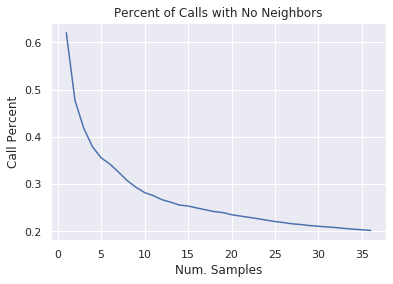

In [124]:
p = sb.lineplot(data=view, x="index", y="noneigh_pct")
hide = p.set(title="Percent of Calls with No Neighbors", xlabel="Num. Samples", ylabel="Call Percent")

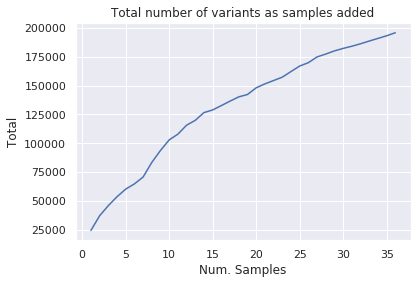

In [122]:
p = sb.lineplot(data=view, x="index", y="total")
hide = p.set(title="Total number of variants as samples added", xlabel="Num. Samples", ylabel="Total")

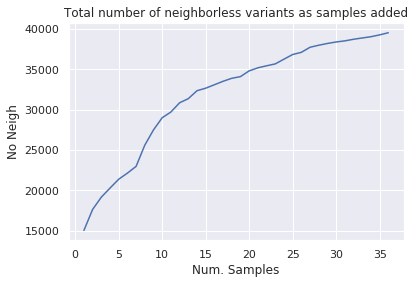

In [125]:
p = sb.lineplot(data=view, x="index", y=0)
hide = p.set(title="Total number of neighborless variants as samples added", xlabel="Num. Samples", ylabel="No Neigh")